# Importation des packages

In [1]:
!pip install keras-tuner
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, AveragePooling2D, Flatten, Dense, Dropout
from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
df_images = pd.read_csv('C:/Users/Gamy/Desktop/Formation fev24_bootcamp_ds/chest_radiography_covid19/datasets/processed/df_images.csv')
df_masks = pd.read_csv('C:/Users/Gamy/Desktop/Formation fev24_bootcamp_ds/chest_radiography_covid19/datasets/processed/df_masks.csv')

## Preprocessing initial

In [6]:
from PIL import Image
import numpy as np
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

def preproc_img(df_images, df_masks, n_img, normalize, files_path, resolution, with_masks):
    np.random.seed(42)

    # Gestion des erreurs
    if resolution[2] != 1 and resolution[2] != 3:
        return print("Le nombre de canaux doit être de 1 (en nuances de gris) ou de 3 (en couleur)")

    if resolution[0] != resolution[1]:
        return print("La largeur de l'image doit être la même que sa hauteur.")

    df_images_selected_list = []
    for label, group in df_images.groupby('LABEL'):
        n_samples = min(len(group), n_img)
        df_images_selected_list.append(group.sample(n=n_samples, replace=False))
    df_images_selected = pd.concat(df_images_selected_list)

    # Initialiser une liste pour stocker les images prétraitées
    images = []

    # Sélectionner le nombre d'image à utiliser par classe
    df_masks_selected = df_masks[df_masks['FILE_NAME'].isin(df_images_selected['FILE_NAME'])] if with_masks else None

    for i in range(len(df_images_selected)):
        img_path = df_images_selected[files_path].iloc[i]
        mask_path = df_masks_selected[files_path].iloc[i] if with_masks else None

        # Charger l'image avec PIL
        img = Image.open(img_path)
        img = img.convert("L")  # Convertir en niveaux de gris

        if resolution[2] == 3:
            img = img.convert("RGB")  # Convertir en mode RGB

        img_resized = img.resize((resolution[0], resolution[1]))

        # Normalisation des valeurs des pixels
        if normalize:
            if resolution[2] == 1:  # Image en nuances de gris
                mean_gray = np.mean([0.485, 0.456, 0.406])
                std_gray = np.mean([0.229, 0.224, 0.225])
                img_normalized = (img_resized / 255.0 - mean_gray) / std_gray
            elif resolution[2] == 3:  # Image en couleur
                img_normalized = np.array(img_resized) / 255.0
                img_normalized -= np.array([0.485, 0.456, 0.406])
                img_normalized /= np.array([0.229, 0.224, 0.225])
        else:
            img_normalized = img_resized

        # Ajouter l'image à la liste
        images.append(img_normalized)

    # Reshaper pour ajouter la dimension du canal
    data = np.array(images).reshape(-1, resolution[0], resolution[1], resolution[2])
    target = df_images_selected['LABEL']

    return data, target


# Modèle basique : LeNet-5

In [8]:
data, target = preproc_img(df_images = df_images, df_masks = df_masks, n_img = 1345, normalize = True, files_path = 'PATH', resolution = [28, 28, 1], with_masks = False)

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.2, random_state = 42)

label_encoder = LabelEncoder()

# Encoder les labels textuels en entiers
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Appliquer l'encodage one-hot
y_train = to_categorical(y_train_encoded)
y_test = to_categorical(y_test_encoded)

# Vérifier la transformation
print("Labels de l'ensemble d'entrainement après encodage one-hot :", y_train.shape)
print("Labels de l'ensemble de test après encodage one-hot :", y_test.shape)

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/Gamy/Desktop/Formation fev24_bootcamp_ds/chest_radiography_covid19/notebooks/covid19-radiography-database/COVID-19_Radiography_Dataset\\COVID\\images\\COVID-37.png'

In [ ]:
print("Classes:", label_encoder.classes_)
print("Numéros correspondants:", label_encoder.transform(label_encoder.classes_))

In [27]:
# Initiation du modèle LeNet-5 de base
inputs = Input(shape = (28, 28, 1))

conv1 = Conv2D(filters = 30, kernel_size = (5, 5), activation = 'relu')(inputs)
pool1 = AveragePooling2D(pool_size = (2, 2))(conv1)

conv2 = Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu')(pool1)
pool2 = AveragePooling2D(pool_size = (2, 2))(conv2)

dropout = Dropout(rate = 0.2)(conv2)

flat = Flatten()(dropout)

dense1 = Dense(units = 128, activation = 'relu')(flat)
dense2 = Dense(units = 4, activation = 'softmax')(dense1)

LeNet = Model(inputs = inputs, outputs = dense2)

LeNet.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
training_history_lenet = LeNet.fit(X_train, y_train, 
                                   epochs = 50, 
                                   batch_size = 256, 
                                   validation_split = 0.2)

Epoch 1/50
14/14 [==============================] - 1s 26ms/step - loss: 1.2752 - accuracy: 0.4360 - val_loss: 1.0581 - val_accuracy: 0.5517
Epoch 2/50
14/14 [==============================] - 0s 17ms/step - loss: 0.9705 - accuracy: 0.5966 - val_loss: 0.8925 - val_accuracy: 0.6132
Epoch 3/50
14/14 [==============================] - 0s 17ms/step - loss: 0.8726 - accuracy: 0.6300 - val_loss: 0.8444 - val_accuracy: 0.6388
Epoch 4/50
14/14 [==============================] - 0s 17ms/step - loss: 0.8212 - accuracy: 0.6500 - val_loss: 0.7978 - val_accuracy: 0.6481
Epoch 5/50
14/14 [==============================] - 0s 16ms/step - loss: 0.7818 - accuracy: 0.6660 - val_loss: 0.7778 - val_accuracy: 0.6597
Epoch 6/50
14/14 [==============================] - 0s 17ms/step - loss: 0.7504 - accuracy: 0.6953 - val_loss: 0.7446 - val_accuracy: 0.6899
Epoch 7/50
14/14 [==============================] - 0s 17ms/step - loss: 0.7024 - accuracy: 0.7049 - val_loss: 0.7161 - val_accuracy: 0.6957
Epoch 8/50
14

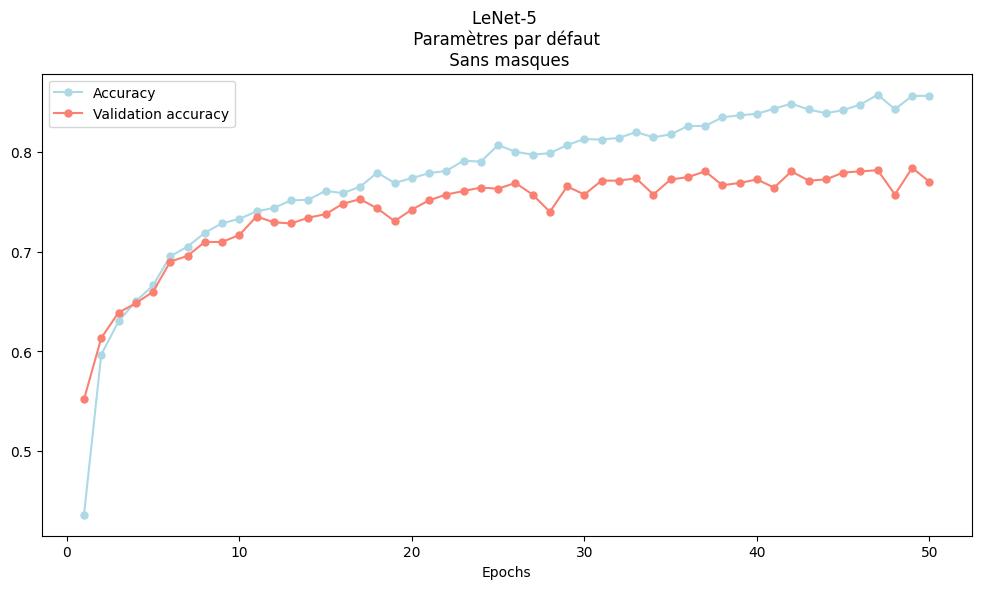

In [28]:
train_acc = training_history_lenet.history['accuracy']
val_acc = training_history_lenet.history['val_accuracy']

# Courbe du score de test du LeNet-5
plt.figure(figsize = (12, 6))
plt.plot(np.arange(1 , 51, 1),
         train_acc,
         color = 'lightblue',
         linestyle = '-',
         marker = 'o',
         markersize = 5,
         label = 'Accuracy')
plt.plot(np.arange(1 , 51, 1),
         val_acc,
         color = 'salmon',
         linestyle = '-',
         marker = 'o',
         markersize = 5,
         label = "Validation accuracy")
plt.xlabel('Epochs')
plt.title("LeNet-5 \n Paramètres par défaut \n Sans masques")
plt.legend()
plt.show()

In [29]:
test_pred_LeNet = LeNet.predict(X_test)
test_pred_LeNet_class = test_pred_LeNet.argmax(axis = 1)
y_test_class = y_test.argmax(axis = 1)

print(metrics.classification_report(y_test_class, test_pred_LeNet_class))

34/34 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.68      0.86      0.76       288
           1       0.80      0.74      0.77       261
           2       0.80      0.62      0.70       259
           3       0.93      0.94      0.94       268

    accuracy                           0.79      1076
   macro avg       0.80      0.79      0.79      1076
weighted avg       0.80      0.79      0.79      1076



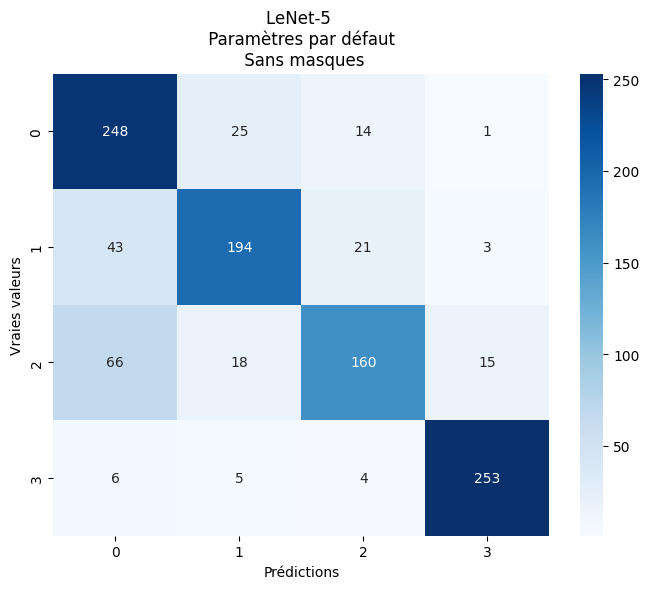

In [31]:
cm = confusion_matrix(y_test_class, test_pred_LeNet_class)
#conf_matrix = confusion_matrix(np.argmax(y_test, axis = 1), y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues")
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.title("LeNet-5 \n Paramètres par défaut \n Sans masques")
plt.show();

# LeNet-5 tests manuels

### Modèle classique

In [36]:
data, target = preproc_img(df_images = df_images, df_masks = df_masks, n_img = 1345, resolution = [28, 28, 1], with_masks = False)

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.2, random_state = 42)

label_encoder = LabelEncoder()

# Encoder les labels textuels en entiers
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Appliquer l'encodage one-hot
y_train = to_categorical(y_train_encoded)
y_test = to_categorical(y_test_encoded)

# Vérifier la transformation
print("Labels de l'ensemble d'entrainement après encodage one-hot :", y_train.shape)
print("Labels de l'ensemble de test après encodage one-hot :", y_test.shape)

Labels de l'ensemble d'entrainement après encodage one-hot : (4304, 4)
Labels de l'ensemble de test après encodage one-hot : (1076, 4)


In [37]:
# Initiation du modèle LeNet-5 de base
inputs = Input(shape = (28, 28, 1))

conv1 = Conv2D(filters = 30, kernel_size = (5, 5), activation = 'relu')(inputs)
pool1 = MaxPooling2D(pool_size = (2, 2))(conv1)

conv2 = Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu')(pool1)
pool2 = MaxPooling2D(pool_size = (2, 2))(conv2)

dropout = Dropout(rate = 0.2)(conv2)

flat = Flatten()(dropout)

dense1 = Dense(units = 256, activation = 'relu')(flat)
dense2 = Dense(units = 4, activation = 'softmax')(dense1)

test_lenet = Model(inputs = inputs, outputs = dense2)

test_lenet.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
training_history_lenet = test_lenet.fit(X_train, y_train, 
                                   epochs = 50, 
                                   batch_size = 256, 
                                   validation_split = 0.2)

Epoch 1/50
14/14 [==============================] - 1s 31ms/step - loss: 1.2639 - accuracy: 0.4714 - val_loss: 1.0101 - val_accuracy: 0.5854
Epoch 2/50
14/14 [==============================] - 0s 22ms/step - loss: 0.9083 - accuracy: 0.6079 - val_loss: 0.8748 - val_accuracy: 0.6202
Epoch 3/50
14/14 [==============================] - 0s 22ms/step - loss: 0.8064 - accuracy: 0.6526 - val_loss: 0.8099 - val_accuracy: 0.6400
Epoch 4/50
14/14 [==============================] - 0s 28ms/step - loss: 0.7850 - accuracy: 0.6564 - val_loss: 0.7666 - val_accuracy: 0.6551
Epoch 5/50
14/14 [==============================] - 0s 24ms/step - loss: 0.7436 - accuracy: 0.6840 - val_loss: 0.7532 - val_accuracy: 0.7003
Epoch 6/50
14/14 [==============================] - 0s 26ms/step - loss: 0.7105 - accuracy: 0.7026 - val_loss: 0.7031 - val_accuracy: 0.6945
Epoch 7/50
14/14 [==============================] - 0s 22ms/step - loss: 0.6744 - accuracy: 0.7183 - val_loss: 0.6781 - val_accuracy: 0.7131
Epoch 8/50
14

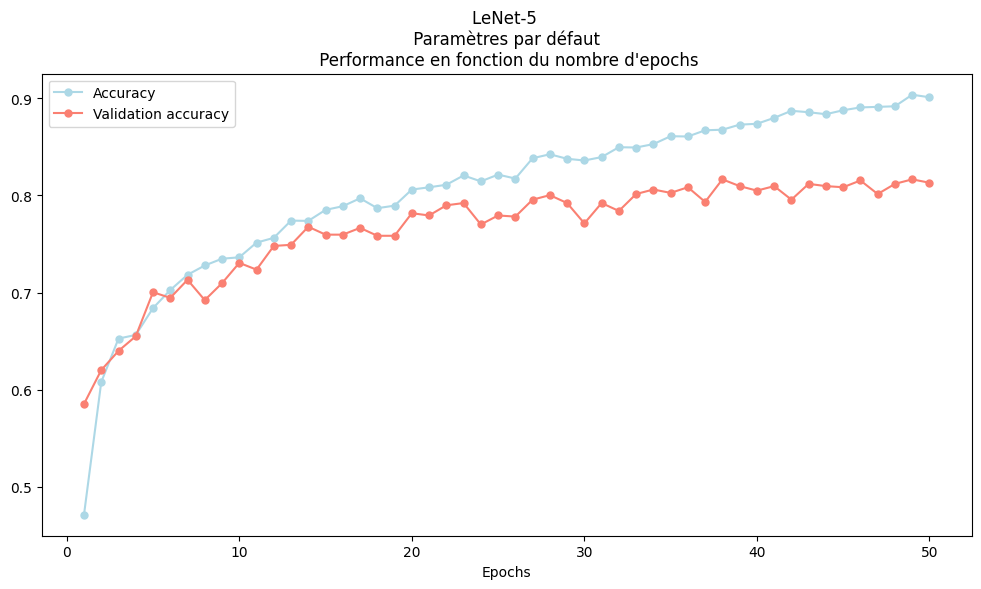

In [38]:
train_acc = training_history_lenet.history['accuracy']
val_acc = training_history_lenet.history['val_accuracy']

# Courbe du score de test du LeNet-5
plt.figure(figsize = (12, 6))
plt.plot(np.arange(1 , 51, 1),
         train_acc,
         color = 'lightblue',
         linestyle = '-',
         marker = 'o',
         markersize = 5,
         label = 'Accuracy')
plt.plot(np.arange(1 , 51, 1),
         val_acc,
         color = 'salmon',
         linestyle = '-',
         marker = 'o',
         markersize = 5,
         label = "Validation accuracy")
plt.xlabel('Epochs')
plt.title("LeNet-5 \n Paramètres par défaut \n Performance en fonction du nombre d'epochs")
plt.legend()
plt.show()

In [ ]:
test_pred_LeNet = test_lenet.predict(X_test)
test_pred_LeNet_class = test_pred_LeNet.argmax(axis = 1)
y_test_class = y_test.argmax(axis = 1)

print(metrics.classification_report(y_test_class, test_pred_LeNet_class))

### Tests de la resolution des images

In [53]:
acc_tot = []
val_acc_tot = []
resolution = []

for i in np.arange(28, 257, 6):
    data, target = preproc_img(df_images = df_images, df_masks = df_masks, n_img = 1345, resolution = [i, i, 1], with_masks = False)
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.2, random_state = 42)
    
    label_encoder = LabelEncoder()
    # Encoder les labels textuels en entiers
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    # Appliquer l'encodage one-hot
    y_train = to_categorical(y_train_encoded)
    y_test = to_categorical(y_test_encoded)

    # Initiation du modèle LeNet-5 de base
    inputs = Input(shape = (i, i, 1))
    conv1 = Conv2D(filters = 30, kernel_size = (5, 5), activation = 'relu')(inputs)
    pool1 = MaxPooling2D(pool_size = (2, 2))(conv1)
    conv2 = Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu')(pool1)
    pool2 = MaxPooling2D(pool_size = (2, 2))(conv2)
    dropout = Dropout(rate = 0.2)(conv2)
    flat = Flatten()(dropout)
    dense1 = Dense(units = 256, activation = 'relu')(flat)
    dense2 = Dense(units = 4, activation = 'softmax')(dense1)
    test_lenet = Model(inputs = inputs, outputs = dense2)
    test_lenet.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    training_history_lenet = test_lenet.fit(X_train, y_train, 
                                    epochs = 20, 
                                    batch_size = 256, 
                                    validation_split = 0.2)
    acc_tot.append(max(training_history_lenet.history['accuracy']))
    val_acc_tot.append(max(training_history_lenet.history['val_accuracy']))
    resolution.append(i)

Epoch 1/20
14/14 [==============================] - 1s 36ms/step - loss: 1.2821 - accuracy: 0.4461 - val_loss: 1.0444 - val_accuracy: 0.5854
Epoch 2/20
14/14 [==============================] - 0s 25ms/step - loss: 0.9248 - accuracy: 0.6035 - val_loss: 0.9372 - val_accuracy: 0.6167
Epoch 3/20
14/14 [==============================] - 0s 22ms/step - loss: 0.8506 - accuracy: 0.6323 - val_loss: 0.8613 - val_accuracy: 0.6132
Epoch 4/20
14/14 [==============================] - 0s 21ms/step - loss: 0.7986 - accuracy: 0.6637 - val_loss: 0.8294 - val_accuracy: 0.6702
Epoch 5/20
14/14 [==============================] - 0s 22ms/step - loss: 0.7423 - accuracy: 0.6945 - val_loss: 0.7809 - val_accuracy: 0.6852
Epoch 6/20
14/14 [==============================] - 0s 23ms/step - loss: 0.7048 - accuracy: 0.7081 - val_loss: 0.7233 - val_accuracy: 0.7003
Epoch 7/20
14/14 [==============================] - 0s 23ms/step - loss: 0.6810 - accuracy: 0.7188 - val_loss: 0.7235 - val_accuracy: 0.6980
Epoch 8/20
14

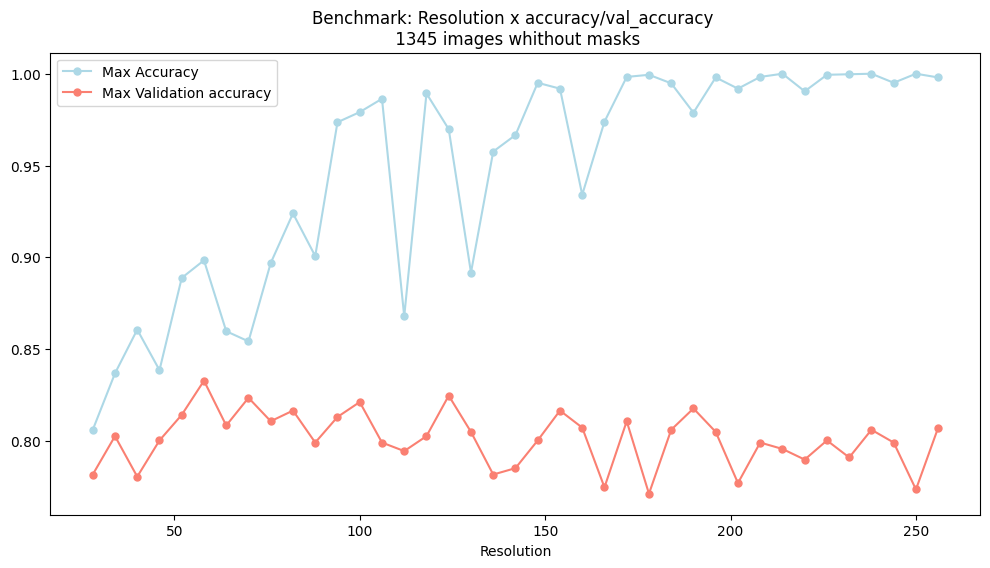

In [55]:
# Courbe du score de test du LeNet-5
plt.figure(figsize = (12, 6))
plt.plot(resolution,
         acc_tot,
         color = 'lightblue',
         linestyle = '-',
         marker = 'o',
         markersize = 5,
         label = 'Max Accuracy')
plt.plot(resolution,
         val_acc_tot,
         color = 'salmon',
         linestyle = '-',
         marker = 'o',
         markersize = 5,
         label = "Max Validation accuracy")
plt.xlabel('Resolution')
plt.title("Benchmark: Resolution x accuracy/val_accuracy \n 1345 images whithout masks")
plt.legend()
plt.show()

### Test du nombre d'images

In [34]:
acc_tot = []
val_acc_tot = []
nimg = []

for i in np.arange(100, 5001, 100):
    data, target = preproc_img(df_images = df_images, df_masks = df_masks, n_img = i, resolution = [28, 28, 1], with_masks = False)
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.2, random_state = 42)
    
    label_encoder = LabelEncoder()
    # Encoder les labels textuels en entiers
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    # Appliquer l'encodage one-hot
    y_train = to_categorical(y_train_encoded)
    y_test = to_categorical(y_test_encoded)

    # Initiation du modèle LeNet-5 de base
    inputs = Input(shape = (28, 28, 1))
    conv1 = Conv2D(filters = 30, kernel_size = (5, 5), activation = 'relu')(inputs)
    pool1 = AveragePooling2D(pool_size = (2, 2))(conv1)
    conv2 = Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu')(pool1)
    pool2 = AveragePooling2D(pool_size = (2, 2))(conv2)
    dropout = Dropout(rate = 0.2)(conv2)
    flat = Flatten()(dropout)
    dense1 = Dense(units = 256, activation = 'relu')(flat)
    dense2 = Dense(units = 4, activation = 'softmax')(dense1)
    test_lenet = Model(inputs = inputs, outputs = dense2)
    test_lenet.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    training_history_lenet = test_lenet.fit(X_train, y_train, 
                                    epochs = 20, 
                                    batch_size = 256, 
                                    validation_split = 0.2)
    acc_tot.append(max(training_history_lenet.history['accuracy']))
    val_acc_tot.append(max(training_history_lenet.history['val_accuracy']))
    nimg.append(i)

Epoch 1/20
1/1 [==============================] - 1s 568ms/step - loss: 1.3824 - accuracy: 0.2852 - val_loss: 1.3508 - val_accuracy: 0.5000
Epoch 2/20
1/1 [==============================] - 0s 72ms/step - loss: 1.3547 - accuracy: 0.3594 - val_loss: 1.3322 - val_accuracy: 0.5312
Epoch 3/20
1/1 [==============================] - 0s 41ms/step - loss: 1.3199 - accuracy: 0.5391 - val_loss: 1.3081 - val_accuracy: 0.5312
Epoch 4/20
1/1 [==============================] - 0s 71ms/step - loss: 1.2754 - accuracy: 0.5508 - val_loss: 1.2414 - val_accuracy: 0.5312
Epoch 5/20
1/1 [==============================] - 0s 74ms/step - loss: 1.2225 - accuracy: 0.5977 - val_loss: 1.1695 - val_accuracy: 0.5938
Epoch 6/20
1/1 [==============================] - 0s 46ms/step - loss: 1.1653 - accuracy: 0.5898 - val_loss: 1.1319 - val_accuracy: 0.5781
Epoch 7/20
1/1 [==============================] - 0s 50ms/step - loss: 1.0962 - accuracy: 0.5938 - val_loss: 1.0851 - val_accuracy: 0.5312
Epoch 8/20
1/1 [==========

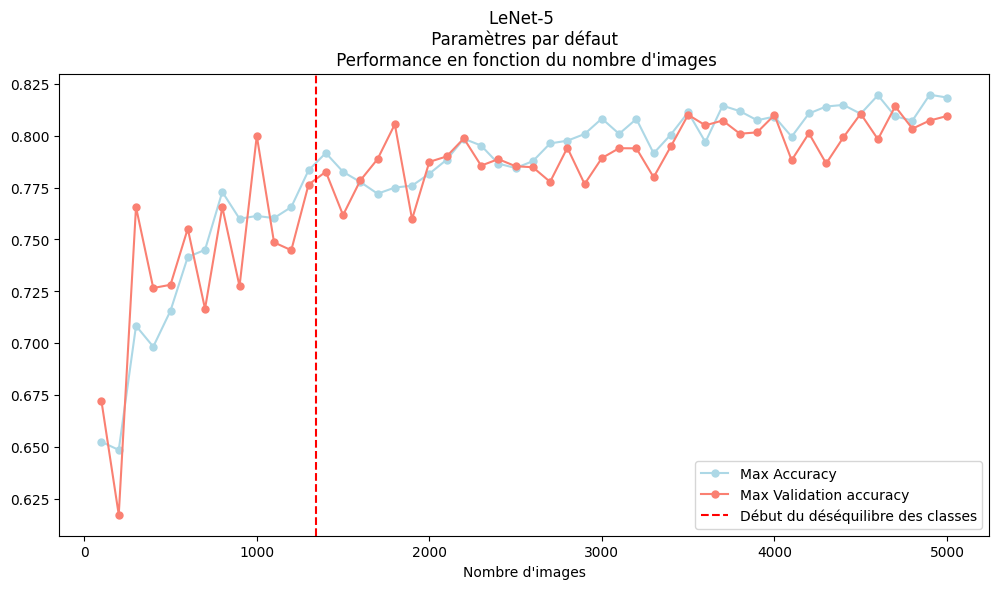

In [35]:
# Courbe du score de test du LeNet-5
plt.figure(figsize = (12, 6))
plt.plot(nimg,
         acc_tot,
         color = 'lightblue',
         linestyle = '-',
         marker = 'o',
         markersize = 5,
         label = 'Max Accuracy')
plt.plot(nimg,
         val_acc_tot,
         color = 'salmon',
         linestyle = '-',
         marker = 'o',
         markersize = 5,
         label = "Max Validation accuracy")
plt.axvline(x = 1345, color = 'red', linestyle = '--', label = 'Début du déséquilibre des classes')
plt.xlabel("Nombre d'images")
plt.title("LeNet-5 \n Paramètres par défaut \n Performance en fonction du nombre d'images")
plt.legend()
plt.show()

# LeNet-5 avec Keras Tuner

In [28]:
data, target = preproc_img(df_images = df_images, df_masks = df_masks, n_img = 1345, resolution = [28, 28, 1], with_masks = True)

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.2, random_state = 42)

label_encoder = LabelEncoder()

# Encoder les labels textuels en entiers
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Appliquer l'encodage one-hot
y_train = to_categorical(y_train_encoded)
y_test = to_categorical(y_test_encoded)

# Vérifier la transformation
print("Labels de l'ensemble d'entrainement après encodage one-hot :", y_train.shape)
print("Labels de l'ensemble de test après encodage one-hot :", y_test.shape)

Labels de l'ensemble d'entrainement après encodage one-hot : (4304, 4)
Labels de l'ensemble de test après encodage one-hot : (1076, 4)


In [99]:
class MyHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes
    
    def build(self, hp):
        inputs = Input(shape = self.input_shape)
        
        conv1 = Conv2D(filters = hp.Int('conv1_filters', min_value = 16, max_value = 320, step = 16), kernel_size = (5, 5), activation = 'relu')(inputs)
        pool1 = MaxPooling2D(pool_size = (2, 2))(conv1)
        
        conv2 = Conv2D(filters = hp.Int('conv2_filters', min_value = 16, max_value = 320, step = 16), kernel_size = (3, 3), activation = 'relu')(pool1)
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
        
        dropout = Dropout(rate = hp.Float('dropout', min_value = 0.1, max_value = 0.5, step = 0.1))(pool2)
        
        flat = Flatten()(dropout)
        
        dense1 = Dense(units = hp.Int('dense1_units', min_value = 16, max_value = 512, step = 128), activation = 'relu')(flat)
        
        outputs = Dense(units = self.num_classes, activation = 'softmax')(dense1)
        
        model = Model(inputs = inputs, outputs = outputs)
        
        model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
        
        return model

In [100]:
# Instancier le modèle hyper
hypermodel = MyHyperModel(input_shape = (28, 28, 1), num_classes = 4)

# Configurer le tuner
tuner = RandomSearch(hypermodel,
                     objective = 'val_accuracy',
                     max_trials = 20,
                     executions_per_trial = 1,
                     directory = 'my_dir',
                     project_name = 'helloworld')

# Lancer la recherche d'hyperparamètres
tuner.search(X_train, y_train, epochs = 50, validation_split = 0.2)

# Obtenir le meilleur modèle
best_model = tuner.get_best_models(num_models = 1)[0]

Trial 50 Complete [00h 03m 26s]
val_accuracy: 0.82314732670784

Best val_accuracy So Far: 0.8263950347900391
Total elapsed time: 04h 09m 34s


In [105]:
# Collecter les performances et les valeurs d'hyperparamètres de tous les essais
val_accuracies = []
hp_conv1_filters = []
hp_conv2_filters = []
hp_dropout = []
hp_dense1_units = []

for trial in tuner.oracle.get_best_trials(num_trials = 50):
    # Accéder aux métriques de validation pour l'essai
    val_accuracy = trial.metrics.get_best_value('val_accuracy')
    val_accuracies.append(val_accuracy)
    
    # Accéder à la valeur d'hyperparamètre spécifique pour l'essai
    hp_value = trial.hyperparameters.get('conv1_filters')
    hp_conv1_filters.append(hp_value)
    hp_value = trial.hyperparameters.get('conv2_filters')
    hp_conv2_filters.append(hp_value)
    hp_value = trial.hyperparameters.get('dropout')
    hp_dropout.append(hp_value)
    hp_value = trial.hyperparameters.get('dense1_units')
    hp_dense1_units.append(hp_value)

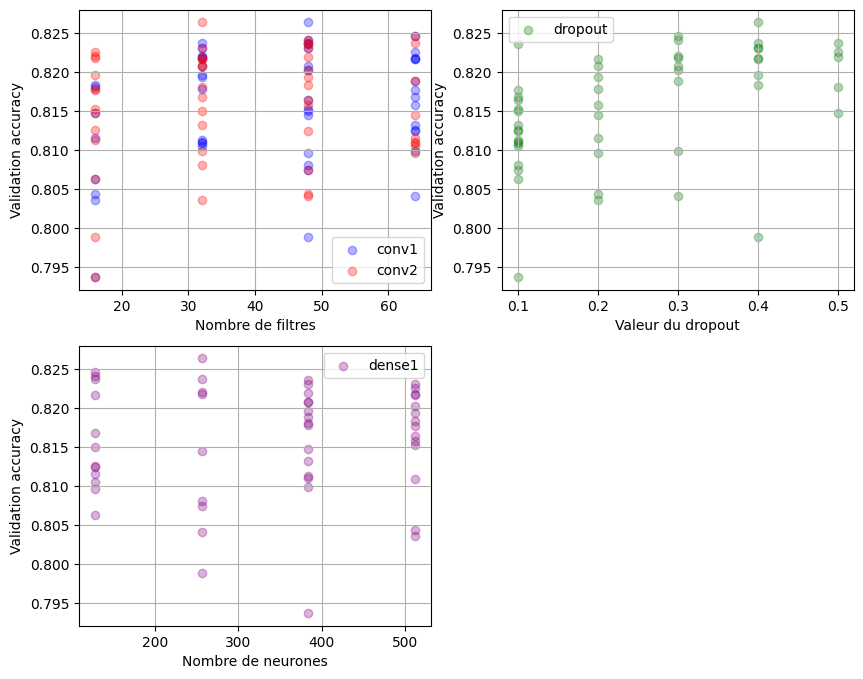

In [106]:
plt.figure(figsize = (10, 8))

plt.subplot(221)
plt.scatter(hp_conv1_filters, val_accuracies, color = 'blue', alpha = 0.3, label = "conv1")
plt.scatter(hp_conv2_filters, val_accuracies, color = 'red', alpha = 0.3, label = "conv2")
plt.xlabel('Nombre de filtres')
plt.ylabel('Validation accuracy')
plt.legend()
plt.grid(True)

plt.subplot(222)
plt.scatter(hp_dropout, val_accuracies, color = 'green', alpha = 0.3, label = "dropout")
plt.xlabel('Valeur du dropout')
plt.ylabel('Validation accuracy')
plt.legend()
plt.grid(True)

plt.subplot(223)
plt.scatter(hp_dense1_units, val_accuracies, color = 'purple', alpha = 0.3, label = "dense1")
plt.xlabel('Nombre de neurones')
plt.ylabel('Validation accuracy')
plt.legend()
plt.grid(True)




Epoch 1/50
424/424 [==============================] - 4s 7ms/step - loss: 0.8026 - accuracy: 0.6772 - val_loss: 0.6546 - val_accuracy: 0.7417
Epoch 2/50
424/424 [==============================] - 3s 7ms/step - loss: 0.6350 - accuracy: 0.7451 - val_loss: 0.5999 - val_accuracy: 0.7614
Epoch 3/50
424/424 [==============================] - 3s 7ms/step - loss: 0.5772 - accuracy: 0.7713 - val_loss: 0.5530 - val_accuracy: 0.7812
Epoch 4/50
424/424 [==============================] - 3s 7ms/step - loss: 0.5321 - accuracy: 0.7910 - val_loss: 0.5447 - val_accuracy: 0.7845
Epoch 5/50
424/424 [==============================] - 3s 7ms/step - loss: 0.5008 - accuracy: 0.8030 - val_loss: 0.5135 - val_accuracy: 0.7927
Epoch 6/50
424/424 [==============================] - 3s 7ms/step - loss: 0.4591 - accuracy: 0.8158 - val_loss: 0.5144 - val_accuracy: 0.7916
Epoch 7/50
424/424 [==============================] - 3s 7ms/step - loss: 0.4192 - accuracy: 0.8351 - val_loss: 0.4982 - val_accuracy: 0.8004
Epoch 

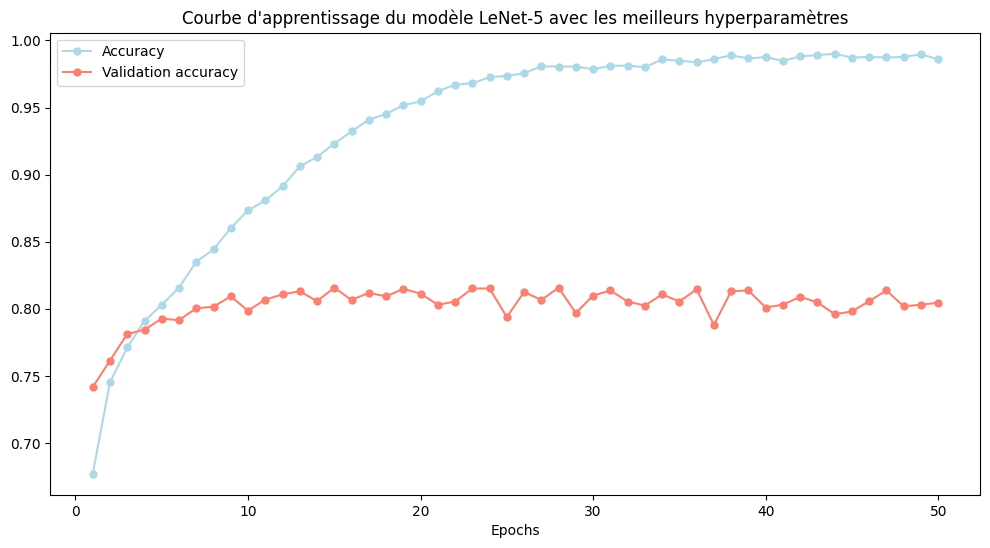

In [108]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials = 15)[0]
model = tuner.hypermodel.build(best_hyperparameters)
history = model.fit(X_train, y_train, epochs = 20, validation_split = 0.2)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Courbe du score de test du LeNet-5
plt.figure(figsize = (12, 6))
plt.plot(np.arange(1 , 51, 1),
         acc,
         color = 'lightblue',
         linestyle = '-',
         marker = 'o',
         markersize = 5,
         label = 'Accuracy')
plt.plot(np.arange(1 , 51, 1),
         val_acc,
         color = 'salmon',
         linestyle = '-',
         marker = 'o',
         markersize = 5,
         label = "Validation accuracy")
plt.xlabel('Epochs')
plt.title("Courbe d'apprentissage du modèle LeNet-5 avec les meilleurs hyperparamètres")
plt.legend()
plt.show()

In [121]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials = 50)[0]

# Afficher les meilleurs hyperparamètres
print("Meilleurs hyperparamètres :")
print(f"Conv_1 filters : {best_hyperparameters.get('conv1_filters')}")
print(f"Conv_2 filters : {best_hyperparameters.get('conv2_filters')}")
print(f"Dropout : {best_hyperparameters.get('dropout')}")
print(f"Dense_1 units : {best_hyperparameters.get('dense1_units')}")

Meilleurs hyperparamètres :
Conv_1 filters : 48
Conv_2 filters : 32
Dropout : 0.4
Dense_1 units : 256
